In [1]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=OPENAI_API_KEY
)

In [3]:
from typing import TypedDict, List

class ReflectState(TypedDict):
    question: str
    answer: str
    reflections: List[str]
    iteration: int

In [4]:
def generate_node(state: ReflectState) -> ReflectState:
    reflection_text = "\n".join(state["reflections"])

    prompt = f"""
Answer the question below.

If previous reflections exist, use them to improve the answer.

Previous reflections:
{reflection_text}

Question:
{state['question']}
"""

    response = llm.invoke(prompt)

    return {
        **state,
        "answer": response.content
    }


In [5]:
def reflect_node(state: ReflectState) -> ReflectState:
    prompt = f"""
You are a self-critique agent.

Question:
{state['question']}

Answer:
{state['answer']}

Identify any issues such as:
- Incorrect reasoning
- Missing details
- Ambiguity

If the answer is good, say "NO ISSUES".
Otherwise, describe the issues clearly.
"""

    response = llm.invoke(prompt)

    reflection = response.content.strip()

    if reflection != "NO ISSUES":
        return {
            **state,
            "reflections": state["reflections"] + [reflection],
            "iteration": state["iteration"] + 1
        }

    return state


In [6]:
def should_continue(state: ReflectState) -> str:
    if state["iteration"] >= 3:
        return "end"
    if state["reflections"] and state["reflections"][-1] != "NO ISSUES":
        return "generate"
    return "end"


In [7]:
from langgraph.graph import StateGraph, END

graph = StateGraph(ReflectState)

graph.add_node("generate", generate_node)
graph.add_node("reflect", reflect_node)

graph.set_entry_point("generate")

graph.add_edge("generate", "reflect")

graph.add_conditional_edges(
    "reflect",
    should_continue,
    {
        "generate": "generate",
        "end": END
    }
)

app = graph.compile()


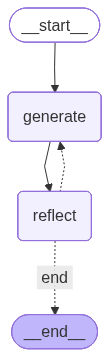

In [8]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))


In [9]:
question = "what is revenue of open ai?"

initial_state: ReflectState = {
    "question": question,
    "answer": "",
    "reflections": [],
    "iteration": 0
}

final_state = app.invoke(initial_state)


In [10]:
print("Final Answer:\n")
print(final_state["answer"])

print("\nReflections:\n")
for r in final_state["reflections"]:
    print("-", r)


Final Answer:

As of my last knowledge update in October 2023, OpenAI's revenue figures were not publicly disclosed in detail. However, estimates suggested that OpenAI's annual revenue could be around $1 billion. It's important to note that this figure is an approximation and may not reflect the most current financial data, as revenue can fluctuate based on various factors, including product launches, partnerships, and market demand.

To provide context, OpenAI's revenue is primarily generated through its API services, partnerships, and subscription models, such as ChatGPT Plus. Compared to other companies in the AI sector, OpenAI's revenue is significant, but specific comparisons with competitors like Google DeepMind or Microsoft are challenging without precise figures.

For the most accurate and up-to-date information regarding OpenAI's revenue, I recommend checking their official website, press releases, or financial reports, as these sources will provide the latest insights into th